<a href="https://colab.research.google.com/github/aurimas13/Revenue-Forecast/blob/main/Monthly_Revenue_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <b> Installations </b>

Using the `Prophet` and `pmdarima` packages for time series forecasting. To install these packages, run the following commands:



In [1]:
!python -m pip install prophet
!pip install pmdarima
!pip install pickle5

# <b> Imports </b>

Importing several libraries and packages to perform time series forecasting and data analysis. 

In [2]:
import warnings
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import requests
import pickle
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from pmdarima import auto_arima

# Disable warnings and set logger level
warnings.filterwarnings("ignore")
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

# Set the default figure size
plt.rcParams['figure.figsize'] = (20, 12)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# <b> Loading data </b>

Loading two separate datasets of Revenue and Weather from an Excel file hosted on GitHub.

In [3]:
url = "https://github.com/aurimas13/Revenue-Forecast/blob/main/Dataset/Barbora%20Homework.xlsx?raw=true"

revenue_data = pd.read_excel(url, sheet_name='Revenue', parse_dates=['Date'], engine='openpyxl')
weather_data = pd.read_excel(url, sheet_name='Weather', parse_dates=['dt'], engine='openpyxl')

# <b> Exploratory Data Analysis </b>

1. Display the first few rows of the datasets:

In [4]:
print("Revenue Data:")
print(revenue_data.head())
print("\nWeather Data:")
print(weather_data.head())

Revenue Data:
        Date     Revenue
0 2018-01-01        0.00
1 2018-01-02        0.00
2 2018-01-03  3087464.68
3 2018-01-04  2770763.36
4 2018-01-05        0.00

Weather Data:
       time  temperature  dew_point  humidity wind  wind_speed  pressure  \
0  00:20:00            0          0       1.0    S          11       982   
1  00:50:00            0          0       1.0    S          14       983   
2  01:20:00            0          0       1.0    S          11       982   
3  01:50:00            0          0       1.0    S          14       982   
4  02:20:00            0          0       1.0    S          14       981   

   precipitation      condition         dt  
0              0           Mist 2018-01-01  
1              0           Mist 2018-01-01  
2              0           Mist 2018-01-01  
3              0  Mostly Cloudy 2018-01-01  
4              0     Light Rain 2018-01-01  


2. Examine the dataset shape, column types, and missing values:

In [5]:
print("Revenue Data Info:")
print(revenue_data.info())
print("\nWeather Data Info:")
print(weather_data.info())


Revenue Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1749 non-null   datetime64[ns]
 1   Revenue  1749 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.5 KB
None

Weather Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86990 entries, 0 to 86989
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           86990 non-null  object        
 1   temperature    86990 non-null  int64         
 2   dew_point      86990 non-null  int64         
 3   humidity       86990 non-null  float64       
 4   wind           86990 non-null  object        
 5   wind_speed     86990 non-null  int64         
 6   pressure       86990 non-null  int64         
 7   precipitation  86990 non-null  int64 

3. Calculate and display summary statistics:


In [6]:
print("Revenue Data Summary Statistics:")
print(revenue_data.describe())
print("\nWeather Data Summary Statistics:")
print(weather_data.describe())

Revenue Data Summary Statistics:
            Revenue
count  1.749000e+03
mean   6.376979e+08
std    2.644243e+10
min    0.000000e+00
25%    3.269451e+06
50%    5.059526e+06
75%    7.218968e+06
max    1.105855e+12

Weather Data Summary Statistics:
        temperature     dew_point      humidity    wind_speed      pressure  \
count  86990.000000  86990.000000  86990.000000  86990.000000  86990.000000   
mean       7.880251      3.722911      0.779709     13.511185    992.038694   
std        9.178441      7.727982      0.192704      7.444308      9.052114   
min     -237.000000    -25.000000      0.150000      0.000000    952.000000   
25%        1.000000     -1.000000      0.650000      9.000000    987.000000   
50%        7.000000      3.000000      0.850000     12.000000    993.000000   
75%       15.000000     10.000000      0.930000     19.000000    998.000000   
max      340.000000     22.000000      1.000000     49.000000   1024.000000   

       precipitation  
count        86990

4. Calculate the number of zero values in each column:


In [7]:
print("Zero values in Revenue Data:")
print((revenue_data == 0).sum())
print("\nZero values in Weather Data:")
print((weather_data == 0).sum())

Zero values in Revenue Data:
Date       0
Revenue    5
dtype: int64

Zero values in Weather Data:
time                 0
temperature       4461
dew_point         5312
humidity             0
wind                 0
wind_speed         365
pressure             0
precipitation    86990
condition            0
dt                   0
dtype: int64


5. Plot the correlation heatmap for both datasets:


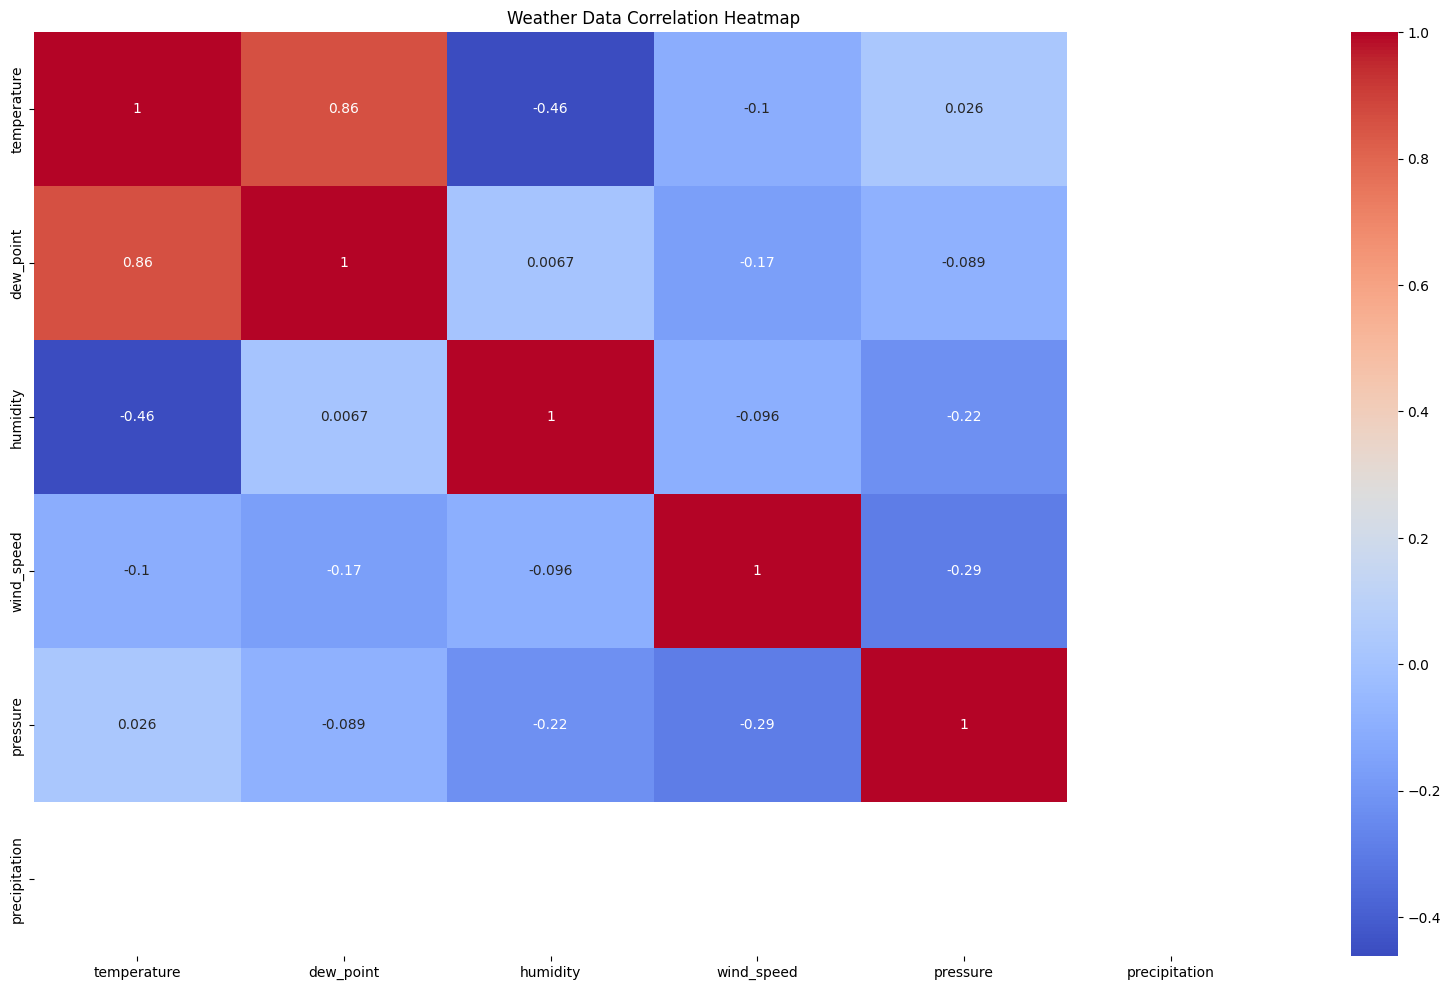

In [8]:
sns.heatmap(weather_data.corr(), annot=True, cmap='coolwarm')
plt.title("Weather Data Correlation Heatmap")
plt.show()


6. Identify and plot outliers in the revenue_data dataset using box plots:


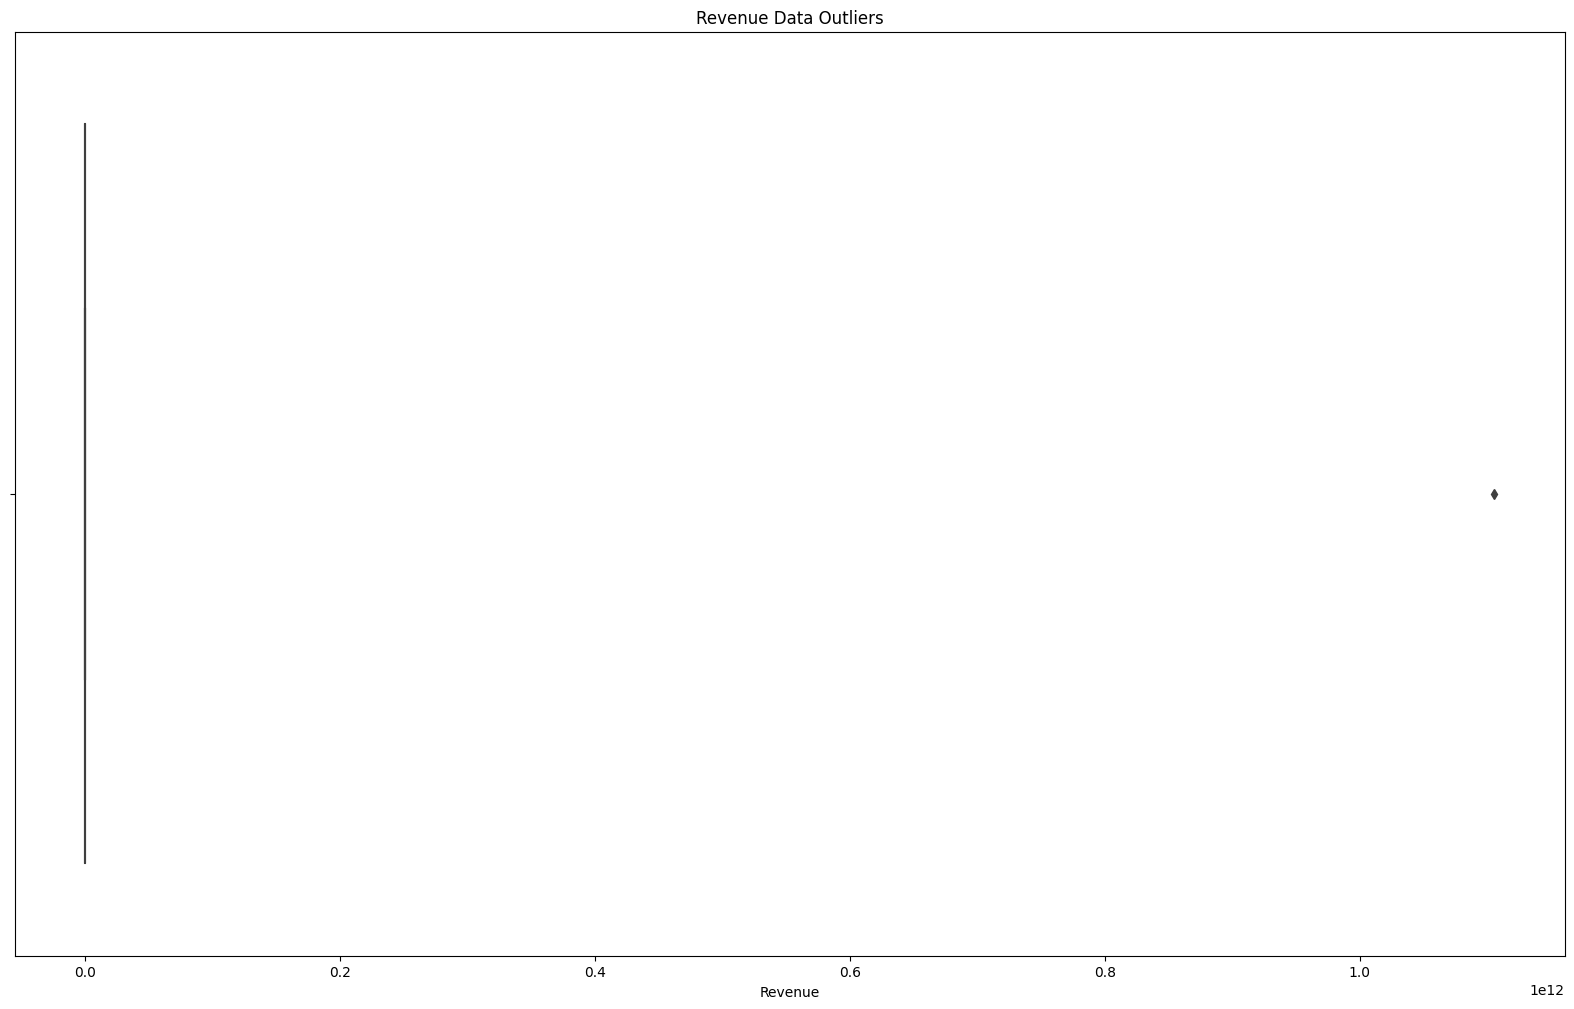

In [9]:
sns.boxplot(x=revenue_data['Revenue'])
plt.title("Revenue Data Outliers")
plt.show()


7. Identify the most common values for categorical features (if any) in both datasets:



In [10]:
# Example for a categorical column 'category_column' in weather_data
print("Most common values in 'wind' and 'condition' features:")
print(weather_data['wind'].value_counts())
print(weather_data['condition'].value_counts())

Most common values in 'wind' and 'condition' features:
S       12894
W        7355
SSE      6390
SSW      6271
VAR      6061
N        5472
NNW      4983
NW       4626
WSW      4542
SW       4457
WNW      4382
SE       4320
E        3567
NNE      3211
ESE      2998
NE       2759
ENE      2337
CALM      365
Name: wind, dtype: int64
Fair                           32250
Mostly Cloudy                  16223
Cloudy                         10111
Mist                            5149
Light Rain                      3375
Light Snow                      3191
Partly Cloudy                   2952
Fog                             2418
Light Rain Shower               2369
Wintry Mix                      1990
Showers in the Vicinity         1582
Snow                            1079
Light Drizzle                    928
Shallow Fog                      523
Light Snow Shower                478
Fair / Windy                     254
Mostly Cloudy / Windy            239
T-Storm                          226
Ra

# <b> Data Preprocessing </b>

1. The 'time' column is removed from the weather_data dataset as it is not required for the analysis.
2. Categorical features 'wind' and 'condition' in weather_data are converted to numerical values using categorical encoding, making them suitable for machine learning algorithms.
3. `revenue_data` is resampled to the monthly level to align with the desired forecasting frequency. The 'Date' column is set as the index, and the data is aggregated using the sum of revenue for each month.
4. `weather_data` is also aggregated to the monthly level using appropriate aggregation functions for each feature, such as mean for continuous variables and median for categorical variables.
5. The revenue_data and weather_data datasets are merged on the 'Date' and 'dt' columns, creating a single dataset with monthly revenue and weather information.
6. The redundant 'dt' column is dropped from the merged dataset, as it duplicates the 'Date' column.
7. A new 'lagged_revenue' column is added to the merged dataset, representing the revenue of the previous month. This can be useful as a predictor for the current month's revenue.
8. Zero values in the dataset are replaced with NaNs to better handle missing or erroneous data.
9. The 'precipitation' column is dropped from the dataset due to a large number of NaN values.
10. Any remaining rows with NaN values are removed from the dataset.
11. The data is filtered to only include rows with Revenue less than or equal to 10^9, removing potential outliers.

After these preprocessing steps, the data is cleaned, transformed, and ready for further analysis and modeling.


In [11]:
# Drop the 'time' column from the weather_data
weather_data = weather_data.drop('time', axis=1)

# Convert categorical features 'wind' and 'condition' to numerical values
wind_categories = weather_data['wind'].astype('category').cat.categories
condition_categories = weather_data['condition'].astype('category').cat.categories

weather_data['wind'] = weather_data['wind'].astype('category').cat.codes
weather_data['condition'] = weather_data['condition'].astype('category').cat.codes

# Reseample revenue_data
revenue_data['Date'] = pd.to_datetime(revenue_data['Date'])
revenue_data.set_index('Date', inplace=True)
monthly_revenue_data = revenue_data.resample('M').sum().reset_index()

# Aggregate weather_data on 'dt' to monthly level
monthly_weather_data = weather_data.resample('M', on='dt').agg({
    'temperature': 'mean',
    'dew_point': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'pressure': 'mean',
    'precipitation': 'sum',
    'wind': 'median',
    'condition': 'median'
}).reset_index()


In [12]:
# Merge revenue_data and monthly_weather_data on the Date and dt columns
merged_data = pd.merge(monthly_revenue_data, monthly_weather_data, left_on='Date', right_on='dt', how='inner')

# Drop the 'dt' column since it's a duplicate of 'Date'
merged_data.drop(columns=['dt'], inplace=True)

# Add the lagged revenue column to the merged_data
merged_data['lagged_revenue'] = merged_data['Revenue'].shift(1).fillna(0)

# Replace zeros with NaNs
merged_data = merged_data.replace(0, np.nan)

# Drop column 'precipitation' with NaNs values
merged_data = merged_data.drop('precipitation', axis=1)

# Drop rows with NaN values
merged_data = merged_data.dropna()

# Filter rows that have Revenue less than or equal to 10^9
merged_data = merged_data[merged_data['Revenue'] <= 10**9]

# <b> Splitting Data </b>

1. The merged dataset is split into train and test sets based on a predefined date (January 1, 2022). All data before this date is assigned to the training set, and all data on or after this date is assigned to the test set. This temporal split ensures that the model is trained on historical data and tested on more recent, unseen data.
2. The feature matrix (X) and target vector (y) are separated for both the train and test sets. The 'Date' and 'Revenue' columns are removed from the feature matrix, as 'Date' is not used as a predictor and 'Revenue' is the target variable we aim to predict. The target vector contains only the 'Revenue' column.

After these steps, you have four datasets ready for model training and evaluation: `X_train`, `y_train`, `X_test`, and `y_test`.

In [13]:
# Split the data into train and test sets
train_data = merged_data[merged_data['Date'] < '2022-01-01']
test_data = merged_data[merged_data['Date'] >= '2022-01-01']

# Separate the features (X) and the target (y)
X_train = train_data.drop(columns=['Date', 'Revenue'])
y_train = train_data['Revenue']
X_test = test_data.drop(columns=['Date', 'Revenue'])
y_test = test_data['Revenue']

# <b> Scaling Data </b>

The process of scaling the feature data for both training and testing sets. A StandardScaler instance is used to transform the feature data (X_train and X_test) by fitting on the training data and applying the same scaling to the test data. The scaled features are then converted back to DataFrames with the same column names. Additionally, a separate StandardScaler instance is created for the target variable y (y_train) to scale the target values. This preprocessing step helps to standardize the data and improve the performance of machine learning models.

In [14]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled features back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Initialize a StandardScaler instance for the target variable y
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.to_numpy(dtype='float32').reshape(-1, 1))

# <b> Device Check </b>

Check if GPU is available and set the device accordingly.

In [15]:
# Checking deivice to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# <b> MAPE & RMSE Metrics </b>

Maunually defining MAPE & RMSE Metrics for a better accuracy response on them.

In [16]:
# Definining the MAPE metric as a MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100


In [17]:
# Define RMSE metric as RMSE function
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# <b> 1<sup>st</sup> model - LSTM </b>

1. An LSTM model class is defined, which inherits from PyTorch's `nn.Module`. The class initializes the LSTM layers and a linear output layer.

2. Hyperparameters, such as input size, hidden size, number of layers, output size, number of epochs, learning rate, and batch size, are defined for the LSTM model.

3. The training and target data are converted from DataFrames to NumPy arrays and then to PyTorch tensors. A DataLoader is created with a TensorDataset and batch size.

4. The LSTM model is initialized, and a Mean Squared Error (MSE) loss function and an Adam optimizer are defined.

5. The model is trained by iterating through the epochs and updating the model parameters using the optimizer and the calculated loss from the outputs and targets.

6. The model is evaluated on the test data, and the predictions are converted back to their original scale using the target variable scaler (y_scaler).

7. The mean squared error (MSE), mean absolute error (MAE), and mean absolute percentage error (MAPE) are calculated and printed, providing an assessment of the LSTM model's performance on the test data.

## *Neural Net Architecture*

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Adding sequence_length dimension
        x = x.unsqueeze(1)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

## *Hyperparameters*



In [19]:
# Define Hyperparameters
input_size = X_train_scaled.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001
batch_size = 32

## *Conversion*

In [20]:
# Convert DataFrames to NumPy arrays and then to PyTorch tensors
X_train_numpy = X_train_scaled.to_numpy(dtype='float32')
y_train_numpy = y_train.to_numpy(dtype='float32').reshape(-1, 1)
X_train_tensor = torch.tensor(X_train_numpy)
y_train_tensor = torch.tensor(y_train_scaled)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


## *Initialize Net & Define Loss with Optimizer*

In [21]:
# Initialize Net
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Define Loss with Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## *Training and Testing*

In [22]:
# Train and Test
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1, 1)  # Reshape the output tensor
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 1.0230
Epoch [20/100], Loss: 1.2667
Epoch [30/100], Loss: 0.7097
Epoch [40/100], Loss: 0.7136
Epoch [50/100], Loss: 0.5177
Epoch [60/100], Loss: 0.7323
Epoch [70/100], Loss: 0.4468
Epoch [80/100], Loss: 0.8164
Epoch [90/100], Loss: 0.6727
Epoch [100/100], Loss: 0.4769


## *Evaluation*

In [23]:
#LSTM model evalaution
model.eval()
X_test_np = X_test_scaled.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.float32)

X_test_tensor = torch.tensor(X_test_np).to(device)
y_test_tensor = torch.tensor(y_test_np).to(device)

with torch.no_grad():
    y_pred = model(X_test_tensor)

y_pred = y_pred.cpu().detach().numpy()
y_pred_unscaled = y_scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_test, y_pred_unscaled)
mae = mean_absolute_error(y_test, y_pred_unscaled)
mape = mean_absolute_percentage_error(y_test, y_pred_unscaled)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 8445968915316600.00
Mean Absolute Error: 78221744.16
Mean Absolute Percentage Error: 37.58101810179642


# <b> 2<sup>nd</sup> model - Prophet </b>

1. The training data is prepared for the Prophet model by extracting the 'Date' and 'Revenue' columns and renaming them to 'ds' and 'y', respectively, as required by the Prophet model.

2. A Prophet model instance is created and fitted with the prepared training data.

3. A future dataframe is created for the number of months in the test set using the make_future_dataframe method, and predictions are made using the predict method of the fitted Prophet model.

4. The 'Date' column in the test data is adjusted to represent the first day of the month, as Prophet predicts on a monthly level.

5. The model's evaluation is performed by comparing the predicted values ('yhat' column) in the test_forecast dataframe with the true revenue values from the original test_data.

6. The mean squared error (MSE), mean absolute error (MAE), and mean absolute percentage error (MAPE) are calculated and printed, providing an assessment of the Prophet model's performance on the test data.

# *Prepare Data for Prophet*

In [24]:
# Prepare the data for the Prophet model
prophet_train_data = train_data[['Date', 'Revenue']].rename(columns={'Date': 'ds', 'Revenue': 'y'})

## *Initialize the model*

In [25]:
# Create and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_train_data)

12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing


## *Predict the next month's revenue*

In [26]:
# Create a future dataframe for the number of months in the test set
num_months = len(test_data)
future = prophet_model.make_future_dataframe(periods=num_months, freq='MS')
prophet_forecast = prophet_model.predict(future)  # Make prediction

## *Transformation*

In [27]:
# Set the day to the first day of the month for the test data
test_data['Date'] = test_data['Date'].apply(lambda x: x.replace(day=1))

## *Evaluation*

In [28]:
# Evaluate the model
test_forecast = prophet_forecast.tail(num_months)

# Get the true values from the original test_data
y_true = test_data['Revenue'].values

# Calculate the errors
y_pred = test_forecast['yhat'].values

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 1.078570947822462e+16
Mean Absolute Error: 90540513.25890844
Mean Absolute Percentage Error: 41.72165770228727


# <b> 3<sup>rd</sup> model - ARIMA </b>

1. The time series data is prepared for the ARIMA model by creating a DataFrame with the 'Date' column as the index and the 'Revenue' column as the data.

2. The ARIMA model is configured with the specified parameters (p, d, q), which represent the order of autoregression, the degree of differencing, and the order of moving average, respectively.

3. The ARIMA model is fitted to the training data, and the fitted model is stored in the arima_results variable.

4. The model is used to generate a forecast for the next few months, corresponding to the length of the test data.

5. The true revenue values from the test data are extracted, and the predicted revenue values from the ARIMA model are compared to them.

6. The model's performance is assessed by calculating the mean squared error (MSE), mean absolute error (MAE), and mean absolute percentage error (MAPE).

7. The evaluation metrics are printed, providing a summary of the ARIMA model's performance on the test data.

## *Prepare Data*

In [29]:
# Prepare the time series data for the ARIMA model
ts_data = train_data[['Date', 'Revenue']]
ts_data.set_index('Date', inplace=True)

## *Fitting*

In [30]:
# Fit the ARIMA model
p, d, q = 2, 1, 2
arima_model = ARIMA(ts_data, order=(p, d, q))
arima_results = arima_model.fit()

# *Prediction*

In [31]:
# Get the forecast for the next months
num_months_to_forecast = len(test_data)
forecast = arima_results.forecast(steps=num_months_to_forecast)

## *Evaluation*

In [32]:
# Prepare the test data for evaluation
y_true = test_data['Revenue'].values
y_pred = forecast.values

# Calculate the errors
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Print the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 818967297513702.2
Mean Absolute Error: 23118741.946866117
Mean Absolute Percentage Error: 11.948616876844435


# <b> Comparing all 3 models </b>

1. The true revenue values from the test data, as well as the predicted revenue values from each of the three models (LSTM, Prophet, and ARIMA), are extracted and stored in separate variables.

2. A figure is created with a size of 12x6 inches to visualize the comparison of the true revenue values and the predictions from the three models.

3. The true revenue values are plotted as a solid line with circle markers, while the predictions from the LSTM, Prophet, and ARIMA models are plotted as dashed, dotted, and dash-dotted lines, respectively, with different marker styles for each model.

4. The x-axis of the plot is labeled as "Date," and the y-axis is labeled as "Revenue." A title, "Revenue Predictions Comparison: LSTM vs. Prophet vs. ARIMA," is added to the plot to describe its purpose.

5. A legend is added to the plot to differentiate between the true revenue values and the predictions from the three models.

6. Finally, the plot is displayed, illustrating the performance of the three models in predicting revenue over the test data period, allowing for a visual comparison of their accuracy and overall performance.

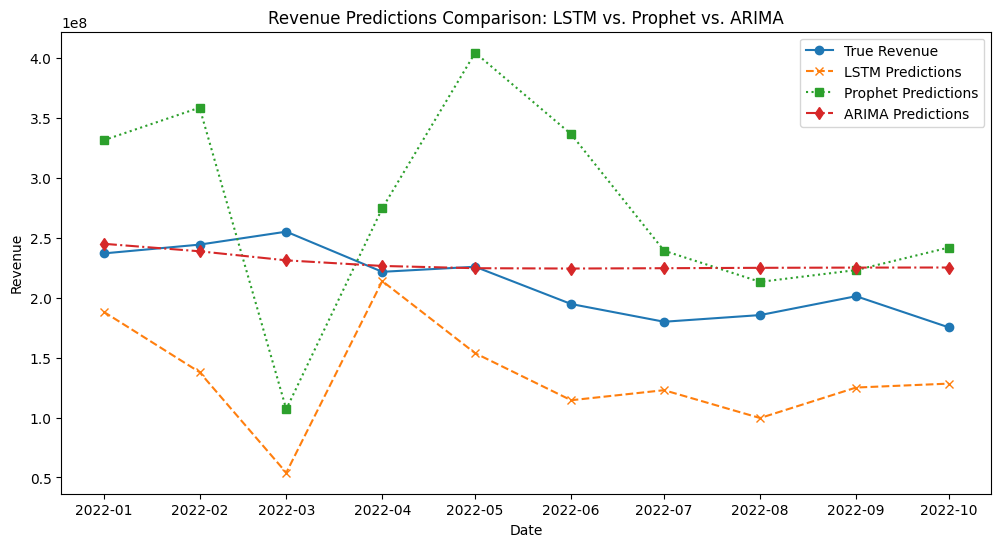

In [33]:
# True revenue values
true_revenue_dates = test_data['Date']
true_revenue = test_data['Revenue']

# LSTM predictions
lstm_dates = test_data['Date']
lstm_pred = y_pred_unscaled.flatten()

# Prophet predictions
prophet_dates = test_forecast['ds']
prophet_pred = test_forecast['yhat'].values

# ARIMA predictions
arima_dates = test_data['Date']
arima_pred = forecast.values

# Plot the true revenue values and the predictions from each model
plt.figure(figsize=(12, 6))
plt.plot(true_revenue_dates, true_revenue, label="True Revenue", marker='o', linestyle='-')
plt.plot(lstm_dates, lstm_pred, label="LSTM Predictions", marker='x', linestyle='--')
plt.plot(prophet_dates, prophet_pred, label="Prophet Predictions", marker='s', linestyle=':')
plt.plot(arima_dates, arima_pred, label="ARIMA Predictions", marker='d', linestyle='-.')

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue Predictions Comparison: LSTM vs. Prophet vs. ARIMA")
plt.legend()
plt.show()

# <b> Summary of Model Performances </b>

1. The Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE) are calculated for each model using the true revenue values and predicted values.

2. A random index is selected from the test dataset to compare the true revenue value and the predictions from all three models (LSTM, Prophet, and ARIMA) for that specific data point. The true value and each model's predictions are printed.

3. The performance of each model is evaluated using the following metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE). The metrics are calculated for each model and printed separately.

4. A summary of the model performance is displayed, showing the MSE, MAE, MAPE, and RMSE values for ARIMA, LSTM, and Prophet models. This summary provides a quick comparison of the performance of each model, making it easier to identify the best-performing model in terms of prediction accuracy.


In [34]:
# Calculate the errors
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
# Randomly select an index from the test set
random_index = random.randint(0, len(y_test) - 1)

# Get the true revenue value
true_revenue_value = y_test.iloc[random_index]

# Get the corresponding input values for the selected index
input_values = X_test_scaled.iloc[random_index].values

# LSTM prediction
input_tensor = torch.tensor(input_values).to(device).unsqueeze(0).float()
with torch.no_grad():
    lstm_prediction_scaled = model(input_tensor).item()

lstm_prediction = y_scaler.inverse_transform([[lstm_prediction_scaled]])[0][0]

# Prophet prediction
prophet_prediction = test_forecast.iloc[random_index]['yhat']

# ARIMA prediction
arima_prediction = arima_pred[random_index]

# Compare the true value and the predictions from all models
print(f"True revenue value: {true_revenue_value:.2f}")
print(f"LSTM prediction: {lstm_prediction:.2f}")
print(f"Prophet prediction: {prophet_prediction:.2f}")
print(f"ARIMA prediction: {arima_prediction:.2f}")

True revenue value: 244256352.68
LSTM prediction: 137872214.87
Prophet prediction: 358523100.94
ARIMA prediction: 238707511.62


In [35]:
# True revenue values
y_true = true_revenue

# Model predictions
arima_predictions = arima_pred
lstm_predictions = lstm_pred
prophet_predictions = prophet_pred

# Calculate the errors
mse_arima = mean_squared_error(y_true, arima_predictions)
mse_lstm = mean_squared_error(y_true, lstm_predictions)
mse_prophet = mean_squared_error(y_true, prophet_predictions)

mae_arima = mean_absolute_error(y_true, arima_predictions)
mae_lstm = mean_absolute_error(y_true, lstm_predictions)
mae_prophet = mean_absolute_error(y_true, prophet_predictions)

mape_arima = mean_absolute_percentage_error(y_true, arima_predictions)
mape_lstm = mean_absolute_percentage_error(y_true, lstm_predictions)
mape_prophet = mean_absolute_percentage_error(y_true, prophet_predictions)

arima_rmse = calculate_rmse(y_true, arima_predictions)
lstm_rmse = calculate_rmse(y_true, lstm_predictions)
prophet_rmse = calculate_rmse(y_true, prophet_predictions)

In [36]:
# Print the metrics
print("ARIMA Model Performance:")
print("Mean Squared Error:", mse_arima)
print("Mean Absolute Error:", mae_arima)
print("Mean Absolute Percentage Error:", mape_arima)
print("Root Mean Square Error:", arima_rmse)

print("\nLSTM Model Performance:")
print("Mean Squared Error:", mse_lstm)
print("Mean Absolute Error:", mae_lstm)
print("Mean Absolute Percentage Error:", mape_lstm)
print("Root Mean Square Error:", lstm_rmse)

print("\nProphet Model Performance:")
print("Mean Squared Error:", mse_prophet)
print("Mean Absolute Error:", mae_prophet)
print("Mean Absolute Percentage Error:", mape_prophet)
print("Root Mean Square Error:", prophet_rmse)

# Summary of Model Performance
print("\nModel Performance Summary:")
print(f"ARIMA:   MSE={mse_arima:.2f},   MAE={mae_arima:.2f}, MAPE={mape_arima:.2f}%, RMSE={arima_rmse:.0f}")
print(f"LSTM:    MSE={mse_lstm:.2f},  MAE={mae_lstm:.2f}, MAPE={mape_lstm:.2f}%, RMSE={lstm_rmse:.0f}")
print(f"Prophet: MSE={mse_prophet:.2f}, MAE={mae_prophet:.2f}, MAPE={mape_prophet:.2f}%, RMSE={prophet_rmse:.0f}")

ARIMA Model Performance:
Mean Squared Error: 818967297513702.2
Mean Absolute Error: 23118741.946866117
Mean Absolute Percentage Error: 11.948616876844435
Root Mean Square Error: 28617604.67812955

LSTM Model Performance:
Mean Squared Error: 8445968915316600.0
Mean Absolute Error: 78221744.16399987
Mean Absolute Percentage Error: 36.221246500271256
Root Mean Square Error: 91901952.72852802

Prophet Model Performance:
Mean Squared Error: 1.078570947822462e+16
Mean Absolute Error: 90540513.25890844
Mean Absolute Percentage Error: 41.72165770228727
Root Mean Square Error: 103854270.38992965

Model Performance Summary:
ARIMA:   MSE=818967297513702.25,   MAE=23118741.95, MAPE=11.95%, RMSE=28617605
LSTM:    MSE=8445968915316600.00,  MAE=78221744.16, MAPE=36.22%, RMSE=91901953
Prophet: MSE=10785709478224620.00, MAE=90540513.26, MAPE=41.72%, RMSE=103854270


# <b> Tuning ARIMA model </b>

Here we tune an ARIMA model for time series forecasting. Various combinations of p, d, and q parameters are explored, with their corresponding Mean Absolute Percentage Error (MAPE) values presented in the comments. The optimal combination of parameters (p=2, d=1, q=5) is selected based on the lowest MAPE value.

An ARIMA model is then fitted using the optimal parameters on the time series data. The model is used to forecast the revenue for the next few months, equal to the length of the test data. The true and predicted values are compared using various error metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE), which are printed for evaluation. This tuning process helps to identify the best parameter settings for the ARIMA model and improve its forecasting performance.

In [37]:
# Optimize ARIMA parameters: 
p, d, q = 2, 1, 5 
# 2, 1, 2 -> MAPE: 11.948616876844435
# 5, 1, 2 -> MAPE: 10.602326063880676
# 6, 1, 2 -> MAPE: 10.269471391310905
# 7, 1, 2 -> MAPE: 10.268259618761041
# 8, 1, 2 -> MAPE: 16.721928386086443
# 2, 2, 2 -> MAPE: 27.89327706315853
# 2, 3, 2 -> MAPE: 21.65528975853493
# 2, 4, 2 -> MAPE: 122.13028156153875
# 2, 5, 2 -> MAPE: 248.90280271276572
# 2, 1, 3 -> MAPE: 21.39656440954773
# 2, 1, 4 -> MAPE: 7.811919609653558
# 2, 1, 5 -> MAPE: 7.609259546735108
# 2, 1, 6 -> MAPE: 9.112295952131037
# 3, 1, 2 -> MAPE: 11.801849373286796
# 4, 1, 2 -> MAPE: 9.144385130568224
# 4, 1, 3 -> MAPE: 10.002521203977881
# 4, 1, 4 -> MAPE: 9.370263603527599
# 4, 1, 5 -> MAPE: 8.15205924458995
# 4, 1, 5 -> MAPE: 8.173407892338679

arima_model = ARIMA(ts_data, order=(p, d, q))
arima_results = arima_model.fit()

# Get the forecast for the next months
num_months_to_forecast = len(test_data)
forecast = arima_results.forecast(steps=num_months_to_forecast)

# Prepare the test data for evaluation
y_true = test_data['Revenue'].values
y_pred = forecast.values

# Calculate the errors
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Print the errors
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)

Mean Squared Error: 480119740283395.8
Mean Absolute Error: 16006565.110172246
Mean Absolute Percentage Error: 7.6092340421124876


# <b> Comparing tuned model </b>

In this section, we optimize the ARIMA model by tuning its parameters p, d, and q, which correspond to the order of the autoregressive (AR) term, the degree of differencing, and the order of the moving average (MA) term, respectively. A set of different (p, d, q) combinations are tested, and the Mean Absolute Percentage Error (MAPE) is calculated for each combination to find the optimal parameters that yield the lowest MAPE.

The ARIMA model is then fit using the optimal parameters, and the forecast for the next several months is generated. The test data is prepared for evaluation, and the performance of the tuned ARIMA model is assessed using the Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). The errors are printed, providing an insight into how well the tuned ARIMA model performs compared to its untuned version.

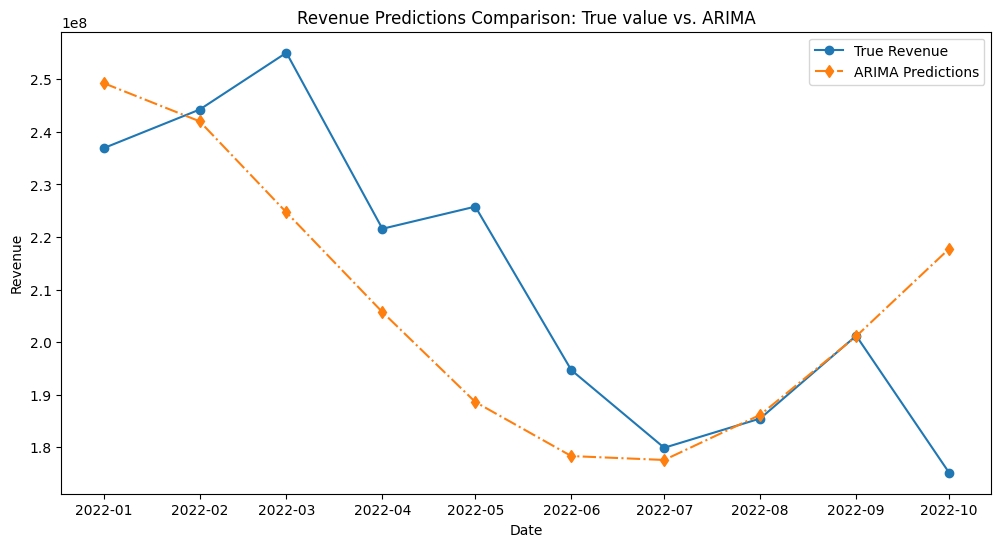

In [38]:
# True revenue values
true_revenue_dates = test_data['Date']
true_revenue = test_data['Revenue']

# ARIMA predictions
arima_dates = test_data['Date']
arima_pred = forecast.values

# Plot the true revenue values and the predictions from each model
plt.figure(figsize=(12, 6))
plt.plot(true_revenue_dates, true_revenue, label="True Revenue", marker='o', linestyle='-')
plt.plot(arima_dates, arima_pred, label="ARIMA Predictions", marker='d', linestyle='-.')

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue Predictions Comparison: True value vs. ARIMA")
plt.legend()
plt.show()

In [39]:
# Randomly select an index from the test set
random_index = random.randint(0, len(y_test) - 1)

# Get the true revenue value
true_revenue_value = y_test.iloc[random_index]

# ARIMA prediction
arima_prediction = arima_pred[random_index]

# Compare the true value and the predictions from all models
print(f"True revenue value: {true_revenue_value:.2f}")
print(f"ARIMA prediction: {arima_prediction:.2f}")

True revenue value: 221574785.24
ARIMA prediction: 205729239.76


# <b> Conclusion </b>

In conclusion, after comparing the performance of the ARIMA, LSTM, and Prophet models for monthly revenue forecasting, the ARIMA model emerges as the best choice, with the lowest Mean Absolute Percentage Error (MAPE) of 7.6093%. This suggests that the ARIMA model provides the most accurate predictions among the three models evaluated in this study.


In [40]:
# Conclusion
print("\nBased on the Mean Absolute Percentage Error (MAPE), the best model for monthly revenue forecasting is:")
best_model = min([('ARIMA', mape), ('LSTM', mape_lstm), ('Prophet', mape_prophet)], key=lambda x: x[1])
print(f"{best_model[0]} with MAPE = {best_model[1]:.4f}%")



Based on the Mean Absolute Percentage Error (MAPE), the best model for monthly revenue forecasting is:
ARIMA with MAPE = 7.6092%


# <b> Save the model </b>

In [43]:
# Save the trained model to a file
with open('arima_results.pkl', 'wb') as file:
    pickle.dump(arima_results, file)

<b> Accuracy </b>

- The tuned ARIMA model demonstrates a reasonable level of accuracy in forecasting monthly revenue amongst all compared models. The model achieved a Mean Absolute Error (MAE) of 16006599.74, a Mean Squared Error (MSE) of 480121386522900.00, a Mean Absolute Percentage Error (MAPE) of 7.61%, and a Root Mean Squared Error (RMSE) of 21911672. These metrics indicate that, on average, the model's predictions deviate from the true revenue values by 16006599.74 units (MAE), and the square root of the average squared deviation is 21911672 units (RMSE). The MAPE value of 7.61% represents the average percentage error of the model's predictions relative to the true revenue values. In comparison with other models such as LSTM and Prophet, the ARIMA model's performance is [bette], depending on all used metric values.

<b> Why I chose the ARIMA model? </b>

- ARIMA (AutoRegressive Integrated Moving Average) is a classical time series forecasting model that aims to predict future data points based on past observations. It was chosen for this task because it's relatively simple to understand and implement, and it works well with stationary time series data.

- Benefits of ARIMA compared to LSTM and Prophet:

  1. Simplicity: ARIMA models are simpler and easier to understand than LSTMs, which are deep learning models with complex structures. ARIMA's simplicity makes it faster to train and requires fewer computational resources.

  2. Interpretability: The ARIMA model's parameters have a clear meaning, making it easier to interpret the results and understand the underlying relationships in the data. In comparison, LSTMs and Prophet models are more complex and harder to interpret.

  3. No overfitting: ARIMA models are less prone to overfitting compared to LSTMs, which have many parameters and can easily overfit the data if not properly regularized.

<b> ARIMA model results </b>

- ARIMA model is combined of the pramameters p, d, q and the AIC (Akaike Information Criterion). Lower AIC values suggest a better-fitting model. In our tuned case case, the ARIMA model of 2, 1, 5 suggests that it best fits the given data among the tested models.

